<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/qml_course/quantum_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install qiskit-aer
!pip install qiskit-machine-learning

In [2]:
import numpy as np
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_histogram

### Full Implementation I

In [3]:
# Number of qubits needed to model real distribution
REAL_DIST_NQUBITS = 2
real_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_circuit.h(0)
real_circuit.cx(0, 1);

In [4]:
# Import qiskit machine learning parameters
from qiskit.circuit import ParameterVector

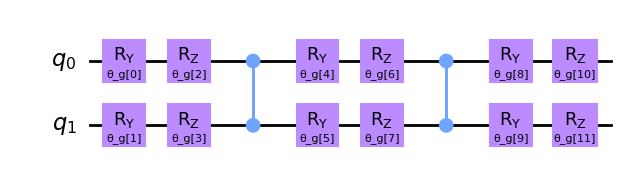

In [5]:
from qiskit.circuit.library import TwoLocal
generator = TwoLocal(REAL_DIST_NQUBITS,
                     # Parameterized single qubit rotations
                     ['ry', 'rz'],
                     'cz',  # Entangling gate
                     'full', # Entanglement structure: all to all
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose() # decompose into standard gates
generator.draw("mpl")

### Variational quantum discriminator

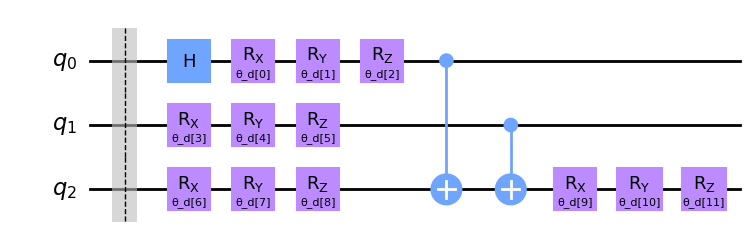

In [6]:
disc_weights = ParameterVector('θ_d', 12)
discriminator = QuantumCircuit(3, name="Discriminator")
discriminator.barrier()
discriminator.h(0)
discriminator.rx(disc_weights[0], 0)
discriminator.ry(disc_weights[1], 0)
discriminator.rz(disc_weights[2], 0)
discriminator.rx(disc_weights[3], 1)
discriminator.ry(disc_weights[4], 1)
discriminator.rz(disc_weights[5], 1)
discriminator.rx(disc_weights[6], 2)
discriminator.ry(disc_weights[7], 2)
discriminator.rz(disc_weights[8], 2)
discriminator.cx(0, 2)
discriminator.cx(1, 2)
discriminator.rx(disc_weights[9], 2)
discriminator.ry(disc_weights[10], 2)
discriminator.rz(disc_weights[11], 2)
discriminator.draw("mpl")

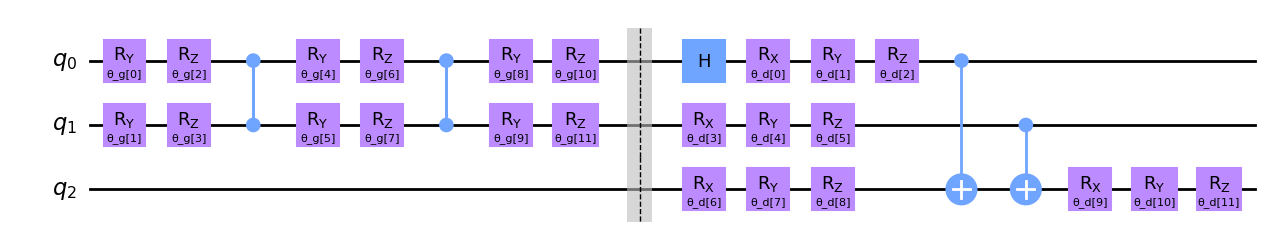

In [7]:
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters
# Need extra qubit for the discriminator
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)
gen_disc_circuit.draw("mpl")

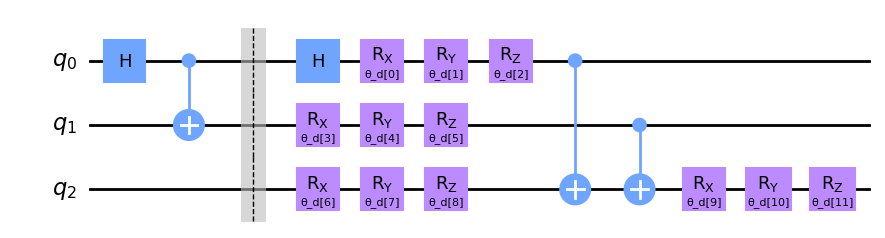

In [8]:
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)
real_disc_circuit.draw("mpl")

In [9]:
# We'll use Statevector to retrieve statevector of given circuit
from qiskit.quantum_info import Statevector
import tensorflow as tf

def generator_cost(gen_params):
    """Generator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    state_probs = Statevector(gen_disc_circuit
                              .bind_parameters(curr_params)
                             ).probabilities()
    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(state_probs[0b100:])
    cost = -prob_fake_true
    return cost

def discriminator_cost(disc_params):
    """Discriminator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    gendisc_probs = Statevector(gen_disc_circuit
                                .bind_parameters(curr_params)
                               ).probabilities()
    realdisc_probs = Statevector(real_disc_circuit.
                                 bind_parameters(disc_params.numpy())
                                ).probabilities()
    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(gendisc_probs[0b100:])
    # Get total prob of measuring |1> on q2
    prob_real_true = np.sum(realdisc_probs[0b100:])
    cost = prob_fake_true - prob_real_true
    return cost

In [10]:
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    """Gauge model performance using Kullback Leibler Divergence"""
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [11]:
!pip install 'qiskit-machine-learning[sparse]'

In [12]:
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# specify QNN to update generator weights
gen_qnn = CircuitQNN(gen_disc_circuit,  # parameterized circuit
                     # frozen input arguements (discriminator weights)
                     gen_disc_circuit.parameters[:N_DPARAMS],
                     # differentiable weights (generator weights)
                     gen_disc_circuit.parameters[N_DPARAMS:],
                     sparse=True, # returns sparse probability vector
                     quantum_instance=qi_sv)

# specify QNNs to update discriminator weights
disc_fake_qnn = CircuitQNN(gen_disc_circuit, # parameterized circuit
                           # frozen input arguments (generator weights)
                           gen_disc_circuit.parameters[N_DPARAMS:],
                           # differentiable weights (discrim. weights)
                           gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           quantum_instance=qi_sv)

disc_real_qnn = CircuitQNN(real_disc_circuit, # parameterized circuit
                           [], # no input parameters
                           # differentiable weights (discrim. weights)
                           gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           quantum_instance=qi_sv)

<ipython-input-12-b5c5e39225c7>:5: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))


In [13]:
import tensorflow as tf
import pickle # to serialize and deserialize variables
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))
gen_params = tf.Variable(init_gen_params)
disc_params = tf.Variable(init_disc_params)

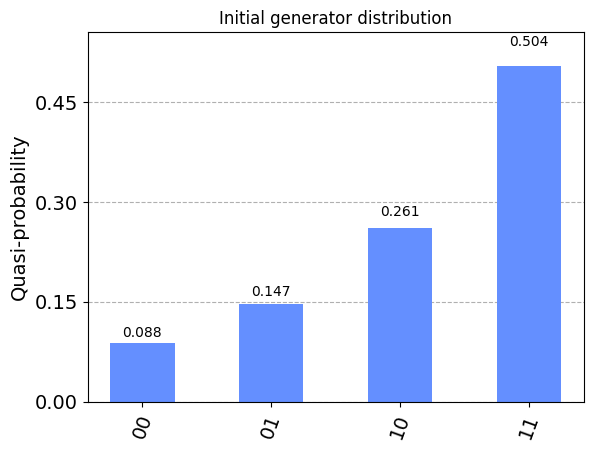

In [14]:
init_gen_circuit = generator.bind_parameters(init_gen_params)
init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, sharey=True)
ax1.set_title("Initial generator distribution")
plot_histogram(init_prob_dict, ax=ax1)

In [15]:
# Initialize Adam optimizer from Keras
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [16]:
# Initialize variables to track metrics while training
best_gen_params = tf.Variable(init_gen_params)
gloss = []
dloss = []
kl_div = []

In [17]:
TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. |"
print(TABLE_HEADERS)
for epoch in range(100):
    #--- Quantum discriminator parameter updates ---#
    D_STEPS = 5 # N discriminator updates per generator update
    for disc_train_step in range(D_STEPS):
        # Partial derivatives wrt θ_D
        d_fake = disc_fake_qnn.backward(gen_params, disc_params
                                       )[1].todense()[0, 0b100:]
        d_fake = np.sum(d_fake, axis=0)
        d_real = disc_real_qnn.backward([], disc_params
                                       )[1].todense()[0, 0b100:]
        d_real = np.sum(d_real, axis=0)
        # Recall Cost_D structure
        grad_dcost = [d_fake[i] - d_real[i] for i in range(N_DPARAMS)]
        grad_dcost = tf.convert_to_tensor(grad_dcost)
        # Update disc params with gradient
        discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                    [disc_params]))
        # Track discriminator loss
        if disc_train_step % D_STEPS == 0:
            dloss.append(discriminator_cost(disc_params))

    #--- Quantum generator parameter updates ---#
    for gen_train_step in range(1):
        # Compute partial derivatives of prob(fake|true) wrt each
        # generator weight
        grads = gen_qnn.backward(disc_params, gen_params)
        grads = grads[1].todense()[0][0b100:]
        # Recall Cost_G structure and the linearity of
        # the derivative operation
        grads = -np.sum(grads, axis=0)
        grads = tf.convert_to_tensor(grads)
        # Update gen params with gradient
        generator_optimizer.apply_gradients(zip([grads], [gen_params]))
        gloss.append(generator_cost(gen_params))

    #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator.bind_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit
                               ).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    if np.min(kl_div) == current_kl:
        # New best
        # serialize & deserialize to simply ensure zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 10 == 0:
        # print table every 10 epochs
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1], kl_div[-1])):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()

Epoch | Generator cost | Discriminator cost | KL Div. |
    0 |         -0.278 |             -0.267 |   0.862 |
   10 |           -0.4 |             -0.599 |   0.765 |
   20 |         -0.475 |             -0.487 |   0.686 |
   30 |         -0.538 |              -0.45 |   0.831 |
   40 |         -0.488 |             -0.467 |   0.905 |
   50 |         -0.559 |             -0.426 |   0.663 |
   60 |         -0.691 |             -0.307 |   0.502 |
   70 |         -0.726 |             -0.244 |    0.35 |
   80 |         -0.807 |             -0.165 |   0.189 |
   90 |         -0.735 |             -0.135 |   0.121 |


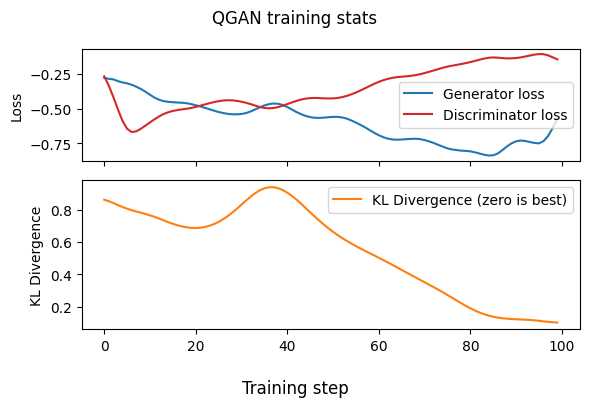

In [18]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout();

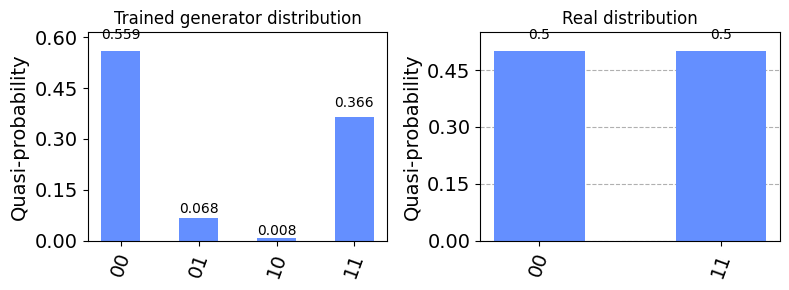

In [19]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.bind_parameters(
    best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
plot_histogram(real_prob_dict, ax=ax2)
ax2.set_title("Real distribution")
fig.tight_layout()

### Full Implementation II

In [22]:
!pip install qiskit-finance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.25.236-py3-none-any.whl size=671349 sha256=1b8c69750cdbff1cf9653fc31b6ae316573d48fd1db9452bbffa224900d409bb
  Stored in directory: /root/.cache/pip/wheels/3b/e5/00/0bf0173d67188fe73a13e3a61412b3f975f60205e3fab93a69
Successfully built docplex


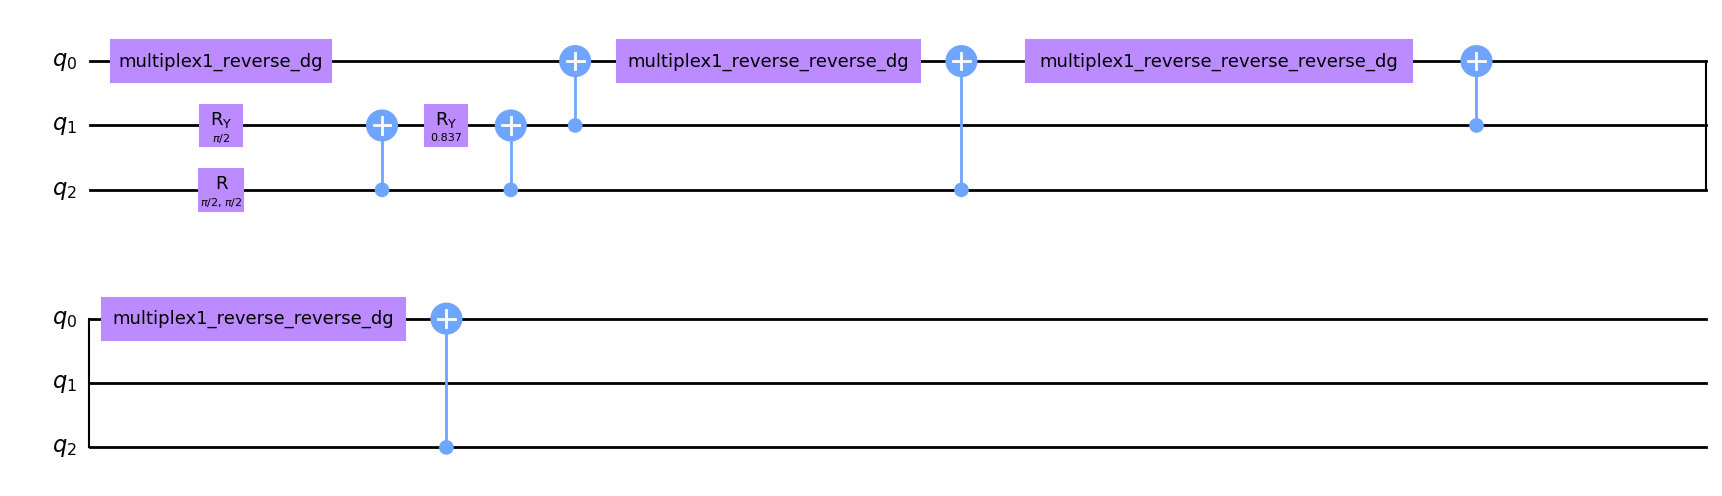

In [24]:
from qiskit_finance.circuit.library import NormalDistribution
REAL_DIST_NQUBITS = 3
real_circuit = NormalDistribution(REAL_DIST_NQUBITS, mu=0, sigma=0.15)
real_circuit = real_circuit.decompose().decompose().decompose()
real_circuit.draw("mpl")

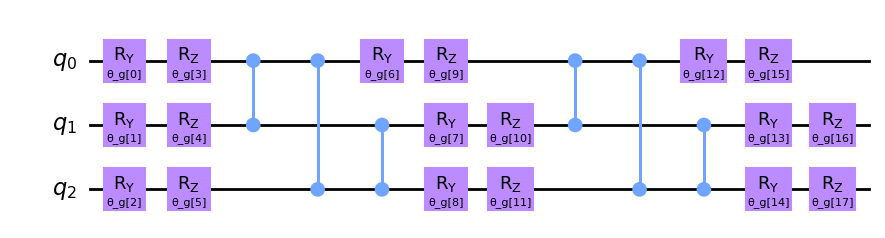

In [26]:
generator = TwoLocal(REAL_DIST_NQUBITS,
                     # Parameterized single qubit rotations
                     ['ry', 'rz'],
                     'cz',  # Entangling gate
                     'full', # Entanglement structure - all to all
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose()
generator.draw("mpl")

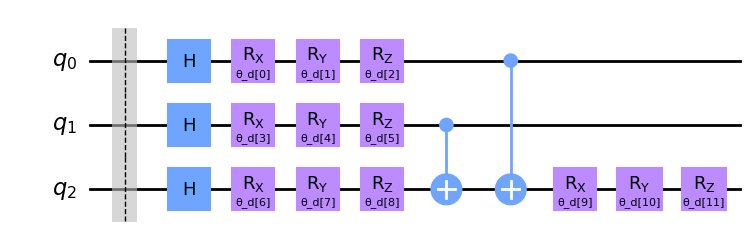

In [29]:
disc_weights = ParameterVector('θ_d', 12)
discriminator = QuantumCircuit(REAL_DIST_NQUBITS, name="Discriminator")
discriminator.barrier()
discriminator.h(0)
discriminator.rx(disc_weights[0], 0)
discriminator.ry(disc_weights[1], 0)
discriminator.rz(disc_weights[2], 0)
discriminator.h(1)
discriminator.rx(disc_weights[3], 1)
discriminator.ry(disc_weights[4], 1)
discriminator.rz(disc_weights[5], 1)
discriminator.h(2)
discriminator.rx(disc_weights[6], 2)
discriminator.ry(disc_weights[7], 2)
discriminator.rz(disc_weights[8], 2)
discriminator.cx(1,2)
discriminator.cx(0,2)
discriminator.rx(disc_weights[9], 2)
discriminator.ry(disc_weights[10], 2)
discriminator.rz(disc_weights[11], 2)
discriminator.draw("mpl")

In [30]:
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters

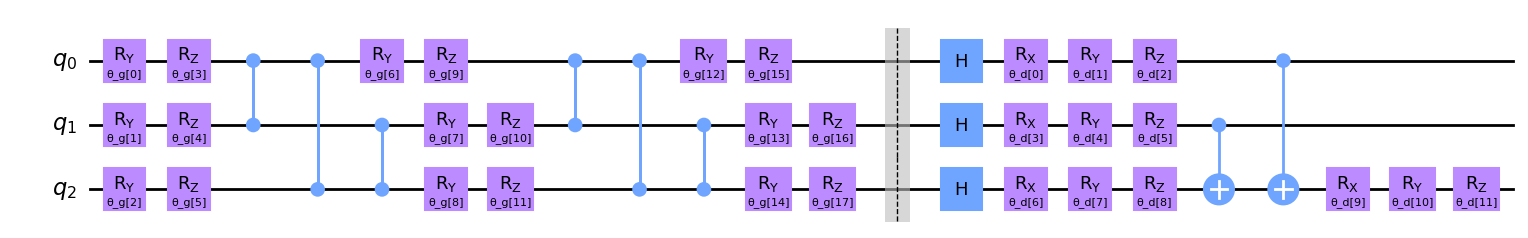

In [31]:
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)
gen_disc_circuit.draw("mpl")

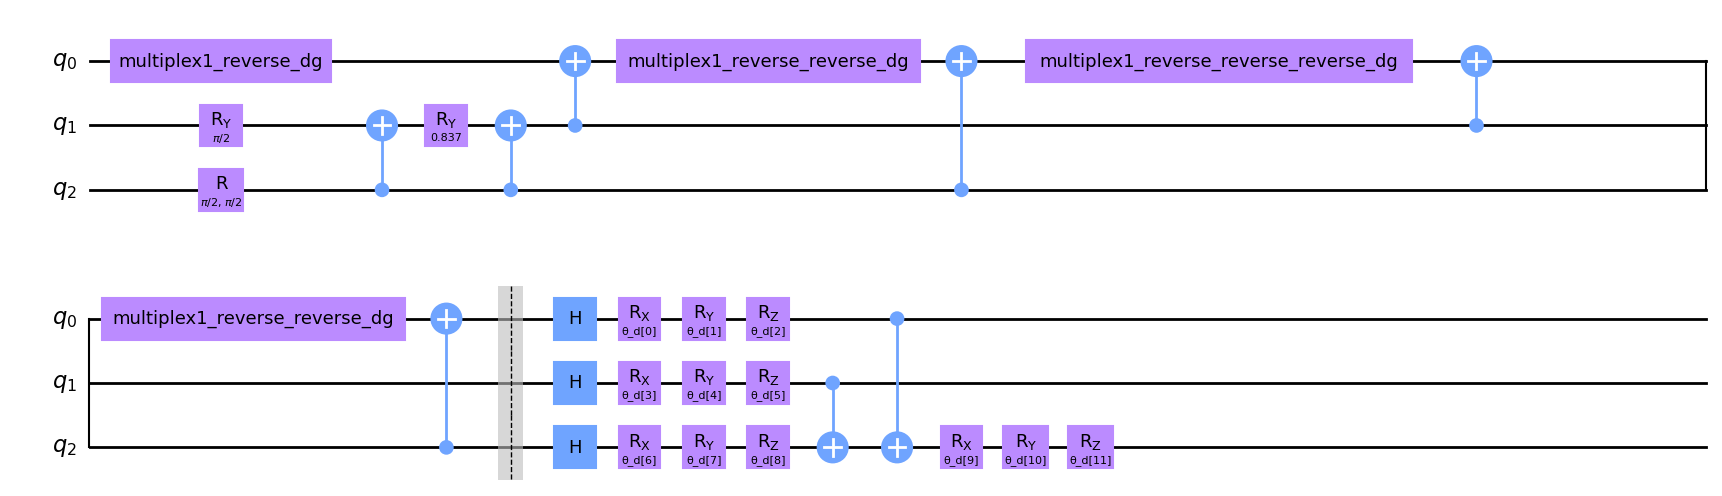

In [32]:
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)
real_disc_circuit.draw("mpl")

In [33]:
from qiskit.opflow import (StateFn, PauliSumOp, Gradient,
                           AerPauliExpectation)
from qiskit_machine_learning.neural_networks import OpflowQNN
expval = AerPauliExpectation()  # method to calculcate expectation values
gradient = Gradient()
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))
# Circuit wave function
gen_disc_sfn = StateFn(gen_disc_circuit)
real_disc_sfn = StateFn(real_disc_circuit)
# construct operator to retrieve Pauli Z expval of the last qubit
H1 = StateFn(PauliSumOp.from_list([('ZII', 1.0)]))
# combine operator and circuit to objective function
gendisc_op = ~H1 @ gen_disc_sfn
realdisc_op = ~H1  @ real_disc_sfn

<ipython-input-33-464388f06818>:4: DeprecationWarning: The class ``qiskit.opflow.expectations.aer_pauli_expectation.AerPauliExpectation`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expval = AerPauliExpectation()  # method to calculcate expectation values
<ipython-input-33-464388f06818>:5: DeprecationWarning: The class ``qiskit.opflow.gradients.gradient.Gradient`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  gradient = Gradient()
<ipython-input-33-464388f06818>:6: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.


In [34]:
# construct OpflowQNN with the two operators, the input parameters,
# the weight parameters, the expected value, and quantum instance.
# |fake> => |0> => 1 ; |real> => |1> => -1
gen_opqnn = OpflowQNN(gendisc_op,
                      # input parameters (discriminator weights)
                      gen_disc_circuit.parameters[:N_DPARAMS],
                      # differentiable weights (generator weights)
                      gen_disc_circuit.parameters[N_DPARAMS:],
                      expval,
                      gradient,
                      qi_sv) # gen wants to to minimize this expval
disc_fake_opqnn = OpflowQNN(gendisc_op,
                            # input parameters (generator weights)
                            gen_disc_circuit.parameters[N_DPARAMS:],
                            # differentiable weights (discrim. weights)
                            gen_disc_circuit.parameters[:N_DPARAMS],
                            expval,
                            gradient,
                            qi_sv) # disc wants to maximize this expval
disc_real_opqnn = OpflowQNN(realdisc_op,
                            [],
                            # differentiable weights (discrim. weights)
                            gen_disc_circuit.parameters[:N_DPARAMS],
                            expval,
                            gradient,
                            qi_sv) # disc wants to minimize this expval

In [36]:
### START
init_gen_params = tf.Variable(np.random.uniform(low=-np.pi,
                                                high=np.pi,
                                                size=(N_GPARAMS)))
init_disc_params = tf.Variable(np.random.uniform(low=-np.pi,
                                                 high=np.pi,
                                                 size=(N_DPARAMS)))
gen_params = init_gen_params
disc_params = init_disc_params
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [38]:
best_gen_params = init_gen_params
gloss, dloss, kl_div = [], [], []
TABLE_HEADERS = "Epoch | Gen. cost | Discrim. cost | KL Div | New best? |"
print(TABLE_HEADERS)
for epoch in range(300):
    D_STEPS = 5
    #--- Quantum discriminator parameter update ---#
    for disc_train_step in range(D_STEPS):
        grad_dcost_fake = disc_fake_opqnn.backward(gen_params,disc_params)[1][0,0]
        grad_dcost_real = disc_real_opqnn.backward([], disc_params)[1][0,0]
        grad_dcost = grad_dcost_real - grad_dcost_fake # as above
        grad_dcost = tf.convert_to_tensor(grad_dcost)
        # update disc_params
        discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                    [disc_params]))
        if disc_train_step % D_STEPS == 0:
            dloss.append(discriminator_cost(disc_params))

    #--- Quantum generator parameter update ---#
    for gen_train_step in range(1):
        # as formulated above
        grad_gcost = gen_opqnn.backward(disc_params,
                                        gen_params)[1][0,0]
        grad_gcost = tf.convert_to_tensor(grad_gcost)
        # update gen_params
        generator_optimizer.apply_gradients(zip([grad_gcost],
                                                [gen_params]))
        gloss.append(generator_cost(gen_params))

    #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator.bind_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit
                               ).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    new_best = (np.min(kl_div) == current_kl)
    if new_best:
        # Store new best generator weights
        # serialize & deserialize to just zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 30 == 0:
        # print table
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1],
                               kl_div[-1], new_best)):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()

Epoch | Gen. cost | Discrim. cost | KL Div | New best? |


ERROR: Failed to load circuits: Invalid parameterization: instruction param position out of range


QiskitError: ignored

In [ ]:
import matplotlib.pyplot as plt
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout();

In [ ]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.bind_parameters(best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,3))
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
plot_histogram(real_prob_dict, ax=ax2)
ax2.set_title("Real distribution")
ax2.set_ylim([0,.5])
fig.tight_layout()